In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential,load_model
from keras import layers,Input
from keras.losses import binary_crossentropy
from keras.layers import Dense
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.constraints import Constraint

## Old data

In [54]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [32]:
state0=np.load('../Data/ML/011624/Q3_state0_1µs_05.npy')
state1=np.load('../Data/ML/011624/Q3_state1_1µs_05.npy')

# state0=np.load('../Data/neel_readout/emu/state0.npy')
# state1=np.load('../Data/neel_readout/emu/state1.npy')
output0=np.zeros((state0.shape[0]))
output1=np.ones((state1.shape[0]))
print(state0.shape,state1.shape)

(9784, 2) (9805, 2)


In [33]:
x=np.concatenate((state0,state1),axis=0)
print(x.shape)
y=np.hstack((output0,output1))
print(y.shape)

(19589, 2)
(19589,)


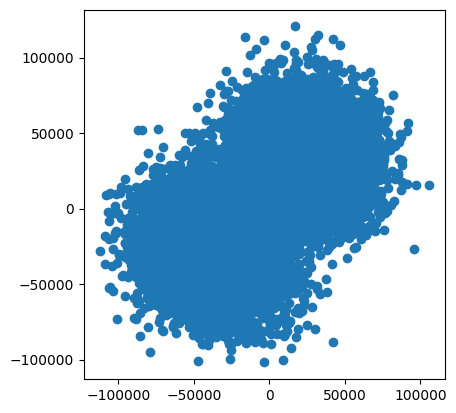

In [34]:
import matplotlib.pyplot as plt 
plt.gca().set_aspect('equal')
plt.scatter(x[:,0],x[:,1])

In [7]:
# x[:,0] += -10000
# x[:,1] += +62000
# print(x[:,0].max(),x[:,0].min())
# print(x[:,1].max(),x[:,1].min())

14344.0 -17403.0
25652.0 -21354.0


0.7011909484863281 0.286529541015625
0.7300586700439453 0.30564117431640625


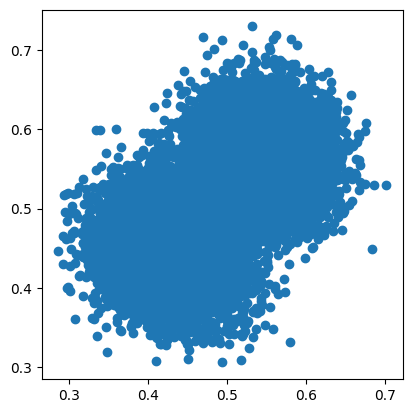

In [35]:
'''Let min and max be 2^18'''

x[:,0]=(x[:,0]+(2**18)-1)/(2**19)
x[:,1]=(x[:,1]+(2**18)-1)/(2**19)
print(x[:,0].max(),x[:,0].min())
print(x[:,1].max(),x[:,1].min())
plt.gca().set_aspect('equal')
plt.scatter(x[:,0],x[:,1])

In [36]:
x=np.round(x,4)
print(x)

[[0.5583 0.6285]
 [0.6135 0.5523]
 [0.4817 0.6253]
 ...
 [0.4752 0.4678]
 [0.4317 0.529 ]
 [0.5048 0.4131]]


In [37]:

# st,ed=700,4700
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=45)
print(x_train.shape)
print(y_train.sum())
print(x_train.shape)

(15671, 2)
7859.0
(15671, 2)


## PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
x=np.vstack((state0,state1))
print(x.shape)
y=np.hstack((output0,output1))
print(y.shape)
sc = StandardScaler()
sc = StandardScaler()
x=x[:,700:2700,:].sum(axis=1)
X= sc.fit_transform(x)
# X_test = sc.transform(x_test)
pca = PCA(n_components = 1)
X = pca.fit_transform(X)
print (pca.explained_variance_)
print (pca.explained_variance_ratio_)
print (pca.explained_variance_ratio_.cumsum())
# X_test = pca.transform(X_test)
print("X shape: {}".format(X.shape))
x_red =X[y[:] == 1, 0]  # Use y[:, 0] for indexing
x_blue = X[y[:] == 0, 0] 

# Create a histogram with two different colors
plt.hist(x_blue, bins=50, color='blue', alpha=0.7, label='y=0')
plt.hist(x_red, bins=50, color='red', alpha=0.7, label='y=1')
# Add labels and legend
plt.xlabel('Scaled values')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

## Logistic Regression

In [38]:
# x_trainC=x_train.reshape((x_train.shape[0],x_train.shape[1]*2))
# x_testC=x_test.reshape((x_test.shape[0],x_test.shape[1]*2))
classifier = LogisticRegression(random_state = 42, max_iter=500)
classifier.fit(x_train, y_train)
print(classifier.score(x_test,y_test))
pred = classifier.predict(x_test)

0.9691168963757019


(0.20559999999999998, 0.8301)

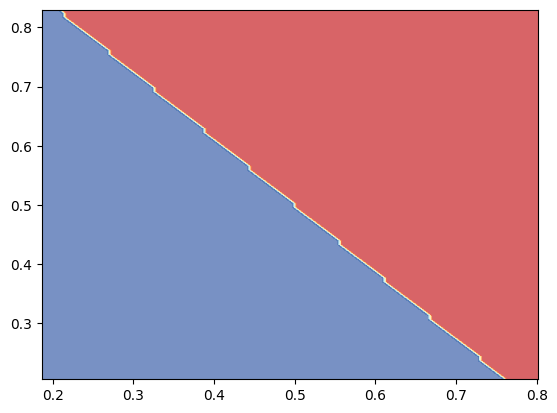

In [39]:
x_min, x_max = x[:, 0].min() - 0.1, x[:,0].max() + 0.1
y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min,x_max, 100), np.linspace(y_min, y_max, 100))
x_in = np.c_[xx.ravel(), yy.ravel()]
y_pred = classifier.predict(x_in)
y_pred = np.round(y_pred).reshape(xx.shape)
plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7 )
# plt.scatter(x[:,0], x[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

## SVM

In [40]:
model=SVC(kernel='rbf',decision_function_shape='ovo',probability=True)
model.fit(x_train,y_train)
print(model.score(x_test,y_test))
pred=model.predict(x_test)

(0.0741, 0.9914)

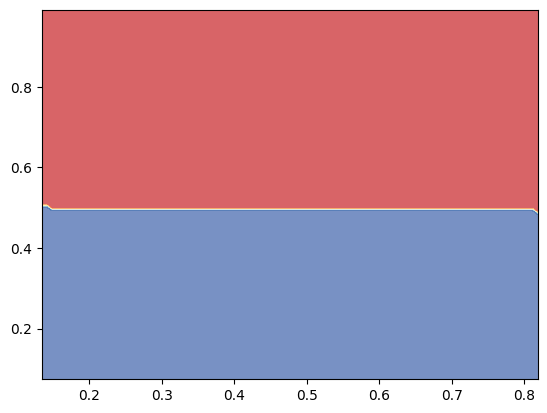

In [27]:
x_min, x_max = x[:, 0].min() - 0.1, x[:,0].max() + 0.1
y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min,x_max, 100), np.linspace(y_min, y_max, 100))
x_in = np.c_[xx.ravel(), yy.ravel()]
y_pred = model.predict(x_in)
y_pred = np.round(y_pred).reshape(xx.shape)
plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7 )
# plt.scatter(x[:,0], x[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

## GMM

In [ ]:
Y=list(zip(np.append(np.mean(state0[:,st:ed,0],axis=1),np.mean(state1[:,st:ed,0],axis=1)),np.append(np.mean(state0[:,st:ed,1],axis=1),np.mean(state1[:,st:ed,1],axis=1))))
gmm_Y=GaussianMixture(n_components=2,covariance_type='full').fit(Y)
bitstring=np.split(gmm_Y.predict(Y),2)
print('P(0|0)=',len(bitstring[0][bitstring[0]==0])/len(bitstring[0]))
print('P(1|1)=',len(bitstring[1][bitstring[1]==1])/len(bitstring[1]))
X=list(zip(np.mean(state0[:,st:ed,0],axis=1),np.mean(state0[:,st:ed,1],axis=1)))
gmm_Y_1=GaussianMixture(n_components=1,covariance_type='spherical').fit(X)
X=list(zip(np.mean(state1[:,st:ed,0],axis=1),np.mean(state1[:,st:ed,1],axis=1)))
gmm_Y_2=GaussianMixture(n_components=1,covariance_type='spherical').fit(X)

## NN

### Model Training

In [12]:
class WeightConstraint(Constraint):
    def __init__(self, min_value=-2, max_value=2, precision=6):
        self.min_value = min_value
        self.max_value = max_value
        self.precision = precision

    def __call__(self, w):
        clipped = K.clip(w, self.min_value, self.max_value)
        return K.round(clipped * 10**self.precision) / 10**self.precision

    def get_config(self):
        return {'min_value': self.min_value, 'max_value': self.max_value, 'precision': self.precision}


def arch():
    model=Sequential()
    model.add(Input(shape=(2)))
    model.add(Dense(8,activation='relu', name='HiddenLayer1',kernel_constraint=WeightConstraint()))
    model.add(Dense(4,activation='relu', name='HiddenLayer2',kernel_constraint=WeightConstraint()))
    model.add(Dense(1,activation='sigmoid', name='OuputLayer',kernel_constraint=WeightConstraint()))
    return model
arch().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer1 (Dense)        (None, 8)                 24        
                                                                 
 HiddenLayer2 (Dense)        (None, 4)                 36        
                                                                 
 OuputLayer (Dense)          (None, 1)                 5         
                                                                 
Total params: 65 (260.00 Byte)
Trainable params: 65 (260.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-02-16 13:34:33.516057: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [81]:
model=arch()
model.summary
opt=SGD( learning_rate=0.01, momentum=0.9)
model.compile(loss=binary_crossentropy, optimizer='adam', metrics=['accuracy'])
model_path="../Model/NN2/tmp/{epoch:02d}-{val_loss:.4f}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [82]:
H=model.fit(x_train,y_train,
          # validation_data=(x_test,y_test),
          validation_split=0.2,
          epochs=100,batch_size=64,
          callbacks=callbacks_list,
          verbose=1)

Epoch 1/100
132/200 [==================>...........] - ETA: 0s - loss: 0.6538 - accuracy: 0.7506
Epoch 1: val_loss improved from inf to 0.54550, saving model to ../Model/NN2/tmp/01-0.5455-0.8672.h5
200/200 [==============================] - 1s 2ms/step - loss: 0.6263 - accuracy: 0.7929 - val_loss: 0.5455 - val_accuracy: 0.8672
Epoch 2/100
141/200 [====================>.........] - ETA: 0s - loss: 0.4846 - accuracy: 0.9135
Epoch 2: val_loss improved from 0.54550 to 0.39179, saving model to ../Model/NN2/tmp/02-0.3918-0.9484.h5
200/200 [==============================] - 0s 2ms/step - loss: 0.4617 - accuracy: 0.9237 - val_loss: 0.3918 - val_accuracy: 0.9484
Epoch 3/100
145/200 [====================>.........] - ETA: 0s - loss: 0.3506 - accuracy: 0.9661
Epoch 3: val_loss improved from 0.39179 to 0.29741, saving model to ../Model/NN2/tmp/03-0.2974-0.9794.h5
200/200 [==============================] - 0s 1ms/step - loss: 0.3376 - accuracy: 0.9680 - val_loss: 0.2974 - val_accuracy: 0.9794
Epoch

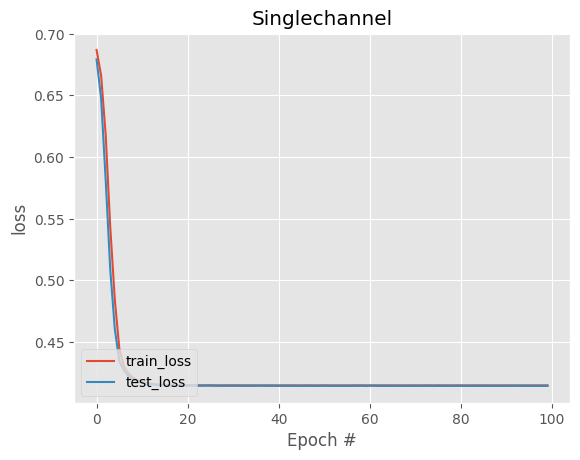

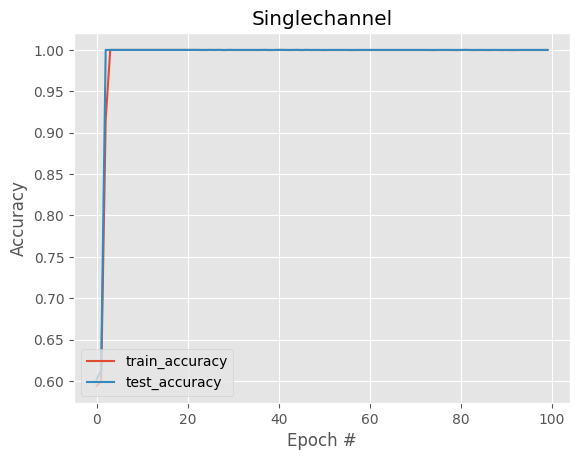

In [57]:
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="test_loss")
plt.title("Singlechannel")
plt.xlabel("Epoch #")
plt.ylabel("loss")
plt.legend(loc="lower left")

N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="test_accuracy")
plt.title("Singlechannel")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

### Model Testing

In [28]:
def custom_objects():
    return {'WeightConstraint': WeightConstraint}
model=load_model('../Model/NN2/tmp/99-0.0012-0.9997.h5', custom_objects=custom_objects())
count=0
count1=0
y_pred=model.predict(x)
for i in range(y_pred.shape[0]):
    if y[i]==0:
        count+=1
        if y_pred[i]<0.5:
            count1+=1
print(count,count1)
print(count1/count,'\n*********')

count=0
count1=0
for i in range(y_pred.shape[0]):
    if y[i]==1:
        count+=1
        if y_pred[i]>=0.5:
            count1+=1
print(count,count1)
print(count1/count)

625/625 [==============================] - 0s 455us/step
11847 11694
0.9870853380602684 
*********
8153 8018
0.9834416779099718


### Weights and Bias extraction

In [29]:
# model=load_model('..//Model/NN2/Best/96.6_Q3.h5', compile=False)
all_weights = model.get_weights()

# Print the shape of each layer's weights and biases
for i, weights in enumerate(all_weights):
    print(f"Layer {i} weights shape:", weights)

Layer 0 weights shape: [[-0.479811   0.262205  -0.512928   0.450973  -0.463872   0.803892
  -0.397623   0.839901 ]
 [ 1.651745  -1.28482   -0.455898  -1.4629819  1.6668429 -0.862538
  -0.678658   1.544448 ]]
Layer 1 weights shape: [-0.37068877  0.80682105  0.          0.90877676 -0.38648224  0.7539839
  0.         -0.82759124]
Layer 2 weights shape: [[-1.997574  -1.998024  -1.703691  -0.638877 ]
 [ 1.993954   1.99393    1.99393   -0.61337  ]
 [ 0.151585   0.478513  -0.440397  -0.476281 ]
 [ 1.993851   1.736019   1.993829  -0.548446 ]
 [-1.997844  -1.5277799 -1.998183  -0.211575 ]
 [ 0.703825   0.922296   1.038215   0.370127 ]
 [-0.092822  -0.169851  -0.165435   0.640414 ]
 [-1.237009  -1.453317  -1.705541  -0.404414 ]]
Layer 3 weights shape: [0.7273538 0.6227822 0.6561562 0.       ]
Layer 4 weights shape: [[ 1.993957]
 [ 1.993982]
 [ 1.994069]
 [-0.685426]]
Layer 5 weights shape: [-7.679932]


In [30]:
all_weights = model.get_weights()
w,b=[],[]
for k,i in enumerate(all_weights):
    if k%2==0:
        for j in i:
            for l in j:
                w.append(l)
    else:
        for j in i:
            b.append(j)
print("Weights : ",w)
print("Bias : ",b)

Weights :  [-0.479811, 0.262205, -0.512928, 0.450973, -0.463872, 0.803892, -0.397623, 0.839901, 1.651745, -1.28482, -0.455898, -1.4629819, 1.6668429, -0.862538, -0.678658, 1.544448, -1.997574, -1.998024, -1.703691, -0.638877, 1.993954, 1.99393, 1.99393, -0.61337, 0.151585, 0.478513, -0.440397, -0.476281, 1.993851, 1.736019, 1.993829, -0.548446, -1.997844, -1.5277799, -1.998183, -0.211575, 0.703825, 0.922296, 1.038215, 0.370127, -0.092822, -0.169851, -0.165435, 0.640414, -1.237009, -1.453317, -1.705541, -0.404414, 1.993957, 1.993982, 1.994069, -0.685426]
Bias :  [-0.37068877, 0.80682105, 0.0, 0.90877676, -0.38648224, 0.7539839, 0.0, -0.82759124, 0.7273538, 0.6227822, 0.6561562, 0.0, -7.679932]


In [31]:
def convert27(x):
    integer,fraction=(divmod(x, 1))
    acc_frac=int(fraction*(2**17))
    fraction_binary=str(bin(acc_frac & 0xFFFFF)[2:].zfill(17))
    if (int(integer)>=0):
        integer_binary=str(bin(int(integer) & 0xFFF)[2:].zfill(10))
    else:
        integer_binary=str(bin(int(integer) & 0b1111111111)[2:].zfill(10))
    binary_value = integer_binary+fraction_binary 
    integer_value = binary_to_integer(binary_value)
    return integer_value
    
def binary_to_integer(binary_string):
    decimal_value = int(binary_string, 2)
    return decimal_value

def convert18(x):
    integer,fraction=(divmod(x, 1))
    acc_frac=int(fraction*(2**12))
    fraction_binary=str(bin(acc_frac & 0xFFFF)[2:].zfill(12))
    if (int(integer)>=0):
        integer_binary=str(bin(int(integer) & 0xFF)[2:].zfill(6))
    else:
        integer_binary=str(bin(int(integer) & 0b111111)[2:].zfill(6))
    binary_value = integer_binary+fraction_binary 
    integer_value = binary_to_integer(binary_value)
    return integer_value

w_bin,b_bin=[],[]
for i in w:
    w_bin.append(convert18(i))
for i in b:
    b_bin.append(convert27(i))

print("Weights : ",w_bin)
print("Bias : ",b_bin)

Weights :  [260178, 1073, 260043, 1847, 260243, 3292, 260515, 3440, 6765, 256881, 260276, 256151, 6827, 258611, 259364, 6326, 253961, 253960, 255165, 259527, 8167, 8167, 8167, 259631, 620, 1959, 260340, 260193, 8166, 7110, 8166, 259897, 253960, 255886, 253959, 261277, 2882, 3777, 4252, 1516, 261763, 261448, 261466, 2623, 257077, 256191, 255158, 260487, 8167, 8167, 8167, 259336]
Bias :  [134169141, 105751, 0, 119115, 134167071, 98826, 0, 134109253, 95335, 81629, 86003, 0, 133211103]


### Confidence Boundary

In [88]:
tmp=[[1, 0]]
tmp = np.reshape(tmp, (1, 2))
layer_outputs = []
for layer in model.layers:
    get_post_activation_output = K.function([model.input], [layer.output])
    layer_outputs.append((get_post_activation_output))

# Get the output of each layer for your input data
post_activation_outputs = []
for get_post_activation_output in layer_outputs:
    post_activation_outputs.append(get_post_activation_output([x])[0])

# Show the output of each layer
for i, post_activation_output in enumerate(post_activation_outputs):
    print("Layer {}: Post-activation output: {}".format(i, post_activation_output))
print(model.predict(tmp))

Layer 0: Post-activation output: [[0.4560019  0.11282796 0.         ... 0.57621336 0.         0.53671056]
 [0.45465818 0.10691243 0.         ... 0.6116093  0.         0.6162457 ]
 [0.46185902 0.1110031  0.         ... 0.5595428  0.         0.5104889 ]
 ...
 [0.         0.5351222  0.         ... 0.84119004 0.         0.        ]
 [0.1490567  0.3525309  0.         ... 0.73179626 0.         0.23875171]
 [0.10901162 0.37567574 0.         ... 0.7926032  0.         0.29421192]]
Layer 1: Post-activation output: [[0.        0.        0.        0.       ]
 [0.        0.        0.        0.       ]
 [0.        0.        0.        0.       ]
 ...
 [3.7120185 3.619791  3.922079  0.       ]
 [1.9756751 1.9298012 2.081057  0.       ]
 [2.2282743 2.1557705 2.316248  0.       ]]
Layer 2: Post-activation output: [[4.6179292e-04]
 [4.6179292e-04]
 [4.6179292e-04]
 ...
 [9.9999958e-01]
 [9.8603642e-01]
 [9.9659967e-01]]
1/1 [==============================] - 0s 52ms/step
[[1.]]


313/313 [==============================] - 0s 475us/step


(0.0741, 0.9914)

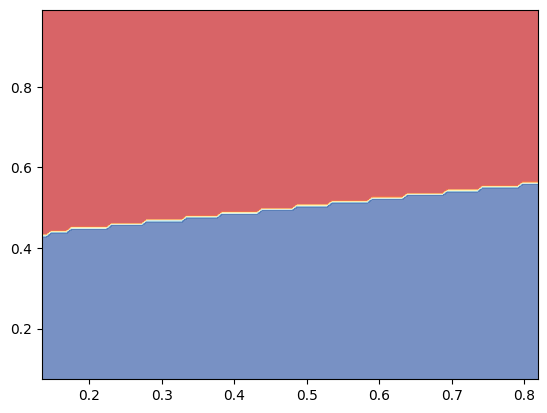

In [23]:
x_min, x_max = x[:, 0].min() - 0.1, x[:,0].max() + 0.1
y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min,x_max, 100), np.linspace(y_min, y_max, 100))
x_in = np.c_[xx.ravel(), yy.ravel()]
y_pred = model.predict(x_in)
y_pred = np.round(y_pred).reshape(xx.shape)
plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7 )
# plt.scatter(x[:,0], x[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [ ]:
np.save('../Model/NN2/Best/Q2_x_text.npy',x_test)
np.save('../Model/NN2/Best/Q2_y_test.npy',y_test)


## MultiChannel

In [ ]:
import numpy as np
import pandas as pd
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
# def plotCluster(s0I,s0Q,s1I,s1Q,e0I,e0Q,e1I,e1Q,f0I,f0Q,f1I,f1Q,):
#     fig = make_subplots(rows=1, cols=1)
#     trace0 = go.Scatter(x=s0I, y=s0Q, name='0-500_|0>',mode='markers',line=dict(color='blue'),marker=dict(size=8, symbol='circle-open'))
#     trace1 = go.Scatter(x=s1I, y=s1Q, name='0-500_|1>',mode='markers',line=dict(color='red'),marker=dict(size=8,symbol='square-open'))
#     trace2 = go.Scatter(x=e0I, y=e0Q, name='500-1000_|0>',mode='markers',line=dict(color='black'),marker=dict(size=8,symbol='star-open'))
#     trace3 = go.Scatter(x=e1I, y=e1Q, name='500-1000_|1>',mode='markers',line=dict(color='green'),marker=dict(size=8, symbol='diamond-open'))
#     trace4 = go.Scatter(x=f0I, y=f0Q, name='1000-1500_|0>',mode='markers',line=dict(color='orange'),marker=dict(size=8,symbol='square-cross-open'))
#     trace5 = go.Scatter(x=f1I, y=f1Q, name='1000-1500_|1>',mode='markers',line=dict(color='pink'),marker=dict(size=8, symbol='diamond-cross-open'))
#     fig.add_trace(trace0)
#     fig.add_trace(trace1)
#     fig.add_trace(trace2)
#     fig.add_trace(trace3)
#     fig.add_trace(trace4)
#     fig.add_trace(trace5)
#     # Set the layout
#     fig.update_layout(
#         title="Signals 0-500-1000-1500",
#         xaxis_title="I",
#         yaxis_title="Q",
#         showlegend=True,
#         width=800,  # Set the width of the plot
#         height=400,  # Set the height of the plot
#     )
#     return fig  

def plotCluster(s0I,s0Q,s1I,s1Q, name1, name2):
    fig = make_subplots(rows=1, cols=1)
    trace0 = go.Scatter(x=s0I, y=s0Q, name=name1,mode='markers',line=dict(color='blue'),marker=dict(size=8, symbol='circle-open'))
    trace1 = go.Scatter(x=s1I, y=s1Q, name=name2,mode='markers',line=dict(color='red'),marker=dict(size=8,symbol='square-open'))
    fig.add_trace(trace0)
    fig.add_trace(trace1)
    # Set the layout
    fig.update_layout(
        title="Signals",
        xaxis_title="I",
        yaxis_title="Q",
        showlegend=True,
        width=800,  # Set the width of the plot
        height=400,  # Set the height of the plot
    )
    return fig  

In [ ]:
# state0_500= np.mean(state0[:,700:1700,:],axis=1)
# state1_500= np.mean(state1[:,700:1700,:],axis=1)
# state0_1000= np.mean(state0[:,1700:2700,:],axis=1)
# state1_1000= np.mean(state1[:,1700:2700,:],axis=1)
# state0_1500= np.mean(state0[:,2700:3700,:],axis=1)
# state1_1500= np.mean(state1[:,2700:3700,:],axis=1)
# state0_4=np.hstack((state0_500,state0_1000,state0_1500))
# state1_4=np.hstack((state1_500,state1_1000,state1_1500))

# indices = np.arange(6000)
# np.random.shuffle(indices)
# selected_indices = indices[:1000]
# random0 = state0_4[selected_indices]
# random1 = state1_4[selected_indices]


# print(random0.shape)

In [ ]:
state0_100= np.sum(state0[:,1500:1700,:],axis=1)
state1_100= np.sum(state1[:,1500:1700,:],axis=1)
state0_200= np.sum(state0[:,1900:2100,:],axis=1)
state1_200= np.sum(state1[:,1900:2100,:],axis=1)
state0_300= np.sum(state0[:,2100:2300,:],axis=1)
state1_300= np.sum(state1[:,2100:2300,:],axis=1)
state0_400= np.sum(state0[:,2300:2500,:],axis=1)
state1_400= np.sum(state1[:,2300:2500,:],axis=1)
state0_500= np.sum(state0[:,2500:2700,:],axis=1)
state1_500= np.sum(state1[:,2500:2700,:],axis=1)
state0_4=np.hstack((state0_100,state0_200,state0_300,state0_400,state0_500))
state1_4=np.hstack((state1_100,state1_200,state1_300,state1_400,state1_500))

indices = np.arange(6000)
np.random.shuffle(indices)
selected_indices = indices[:1000]
random0 = state0_4[selected_indices]
random1 = state1_4[selected_indices]


print(random0.shape)

In [ ]:
# plotCluster(random0[:,0], random0[:,1], random1[:,0], random1[:,1], random0[:, 2], random0[:, 3], random1[:,2], random1[:,3],random0[:, 4], random0[:, 5], random1[:,4], random1[:,5])
plotCluster(random0[:,0], random0[:,1], random1[:,0], random1[:,1],'500-600_|0>', '500-600_|1>').show()
plotCluster(random0[:, 2], random0[:, 3], random1[:,2], random1[:,3],'600-700_|0>', '600-700_|1>').show()
plotCluster(random0[:, 4], random0[:, 5], random1[:,4], random1[:,5],'700-800_|0>', '700-800_|1>').show()
plotCluster(random0[:,6], random0[:,7], random1[:,6], random1[:,7],'800-900_|0>', '800-900_|1>').show()
plotCluster(random0[:, 8], random0[:, 9], random1[:,8], random1[:,9],'900-1000_|0>', '900-1000_|1>').show()
# plotCluster(np.sum(state0[selected_indices,1700:3700, 0],axis=1), np.sum(state0[selected_indices,1700:3700, 1],axis=1), np.sum(state1[selected_indices,1700:3700,0],axis=1), np.sum(state1[selected_indices,1700:3700,1],axis=1),'900-1000_|0>', '900-1000_|1>').show()


In [ ]:
x=np.vstack((state0_4,state1_4))
print(x.shape)
y=np.hstack((output0,output1))
print(y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=45)
print(x_train.shape)
print(y_train.sum())

In [ ]:
def arch():
    model=Sequential()
    model.add(Input(shape=(10), name='Input Layer'))
    model.add(Dense(16,activation='relu', name='HiddenLayer1'))
    model.add(Dense(4,activation='relu', name='HiddenLayer2'))
    model.add(Dense(1,activation='sigmoid', name='OuputLayer'))
    return model
arch().summary()

model=arch()
model.summary
opt=SGD( learning_rate=0.01, momentum=0.9)
model.compile(loss=binary_crossentropy, optimizer='adam', metrics=['accuracy'])
model_path="../Model/NN2/tmp/{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

H=model.fit(x_train,y_train,
          validation_split=0.2,
          epochs=100,batch_size=64,
        #   callbacks=callbacks_list,
          verbose=1)
# model=load_model('../Model/NN2/tmp/29-0.7716.h5', compile=False)
count=0
count1=0
y_pred=model.predict(x_test)
for i in range(y_pred.shape[0]):
    if y_test[i]==0:
        count+=1
        if y_pred[i]<=0.5:
            count1+=1
print(count,count1)

count=0
count1=0
y_pred=model.predict(x_test)
for i in range(y_pred.shape[0]):
    if y_test[i]==1:
        count+=1
        if y_pred[i]>=0.5:
            count1+=1
print(count,count1)

In [ ]:
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="test_loss")
plt.title("Multichannel")
plt.xlabel("Epoch #")
plt.ylabel("loss")
plt.legend(loc="lower left")

N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="test_accuracy")
plt.title("Multichannel")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


threshold = 0.5
y_pred = (y_pred > threshold).astype(int)
conf_mat = confusion_matrix(y_test, y_pred)

# Calculate percentages
conf_mat_percentage = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_mat)

# Create a heatmap for better visualization with percentages
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat_percentage, annot=True, fmt=".2%", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Percentages)")
plt.show()

## New

In [ ]:
state0=np.stack((np.load('../Data/neel_readout/120923/state0_15µs_cos.npy').real,np.load('../Data/neel_readout/120923/state0_15µs_cos.npy').imag),axis=1)
state1=np.stack((np.load('../Data/neel_readout/120923/state1_15µs_cos.npy').real,np.load('../Data/neel_readout/120923/state1_15µs_cos.npy').imag),axis=1)
output0=np.zeros((state0.shape[0]))
output1=np.ones((state1.shape[0]))
print(state0.shape)

In [ ]:
x=np.vstack((state0,state1))
print(x.shape)
y=np.hstack((output0,output1))
print(y.shape)

min,max= -(2**20),(2**20)
print('Min: %.3f, Max: %.3f' % (x.min(), x.max()))
x= (x-min)/(max-min)
print('Min: %.3f, Max: %.3f' % (x.min(), x.max()))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.80, random_state=45)
print(x_train.shape)
print(y_train.sum())

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X= sc.fit_transform(x)
pca = PCA(n_components = 1)
X = pca.fit_transform(X)
print (pca.explained_variance_)
print (pca.explained_variance_ratio_)
print (pca.explained_variance_ratio_.cumsum())
# X_test = pca.transform(X_test)
print("X shape: {}".format(X.shape))
x_red =X[y[:] == 1, 0]  # Use y[:, 0] for indexing
x_blue = X[y[:] == 0, 0] 

# Create a histogram with two different colors
plt.hist(x_blue, bins=50, color='blue', alpha=0.7, label='y=0')
plt.hist(x_red, bins=50, color='red', alpha=0.7, label='y=1')
# Add labels and legend
plt.xlabel('Scaled values')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

In [ ]:
classifier = LogisticRegression(random_state = 42, max_iter=500)
classifier.fit(x_train, y_train)
print(classifier.score(x_test,y_test))
pred = classifier.predict(x_test)

In [ ]:
model=SVC(decision_function_shape='ovo')
model.fit(x_train,y_train)
print(model.score(x_test,y_test))
pred=model.predict(x_test)

In [ ]:
def arch():
    model=Sequential()
    model.add(Input(shape=(2), name='Input Layer'))
    model.add(Dense(8,activation='relu', name='HiddenLayer1'))
    model.add(Dense(4,activation='relu', name='HiddenLayer2'))
    model.add(Dense(1,activation='sigmoid', name='OuputLayer'))
    return model
arch().summary()

model=arch()
model.summary
opt=SGD( learning_rate=0.01, momentum=0.9)
model.compile(loss=binary_crossentropy, optimizer='adam', metrics=['accuracy'])
model_path="../Model/NN2/tmp/{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

H=model.fit(x_train,y_train,
          validation_split=0.2,
          epochs=100,batch_size=64,
        #   callbacks=callbacks_list,
          verbose=1)
# model=load_model('../Model/NN2/tmp/29-0.7716.h5', compile=False)
count=0
count1=0
y_pred=model.predict(x_test)
for i in range(y_pred.shape[0]):
    if y_test[i]==0:
        count+=1
        if y_pred[i]<=0.5:
            count1+=1
print(count,count1)

count=0
count1=0
y_pred=model.predict(x_test)
for i in range(y_pred.shape[0]):
    if y_test[i]==1:
        count+=1
        if y_pred[i]>=0.5:
            count1+=1
print(count,count1)